In [ ]:
import json
import torch
import ast
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('..')
from auto_eval_utils import registered_simple_metrics, registered_helpers
from model import HeadOutputs
from datasets import load_from_disk, Dataset
from tqdm import tqdm
from visualize_eval import *

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

/home/connor/miniconda3/envs/lmsys/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('timestamps/val_timestamps.json', 'r') as file:
    timestamps = json.load(file)

In [ ]:
def plot_training_strategies_comparison(paths_with_labels, title='Comparison of Training Strategies on Chronological Val Data', ncols = 4):
    plt.style.use('seaborn-v0_8-muted')
    fig, ax = plt.subplots(figsize=(16, 12))

    for path, label in paths_with_labels:
        with open(path, 'r') as file:
            data = json.load(file)

        data_int = {int(k): {int(inner_k): v for inner_k, v in inner_dict.items()} for k, inner_dict in data.items()}

        last_model_cp = max(data_int.keys())
        if last_model_cp not in data_int:
            continue

        performance = data_int[last_model_cp]
        performance_series = pd.Series(performance).sort_index()
        
        x_vals = [pd.to_datetime(timestamps[str(val)]['end_tstamp'], unit='s') for val in performance_series.index]
        
        linestyle = '--' if 'Shuffled Training (Oracle)' in label else '-'
        
        ax.plot(
            x_vals,
            performance_series.values,
            marker='o',
            linewidth=2,
            linestyle=linestyle,
            label=label
        )

    ax.set_xlabel('Timestamp', fontsize=16, labelpad=10)
    ax.set_ylabel('Loss', fontsize=16, labelpad=10)

    ax.tick_params(axis='both', which='major', labelsize=16)


    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.1),
        ncol=ncols,
        fontsize=14,
        title='Training Strategy',
        title_fontsize=16,
        frameon=False
    )

    fig.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()

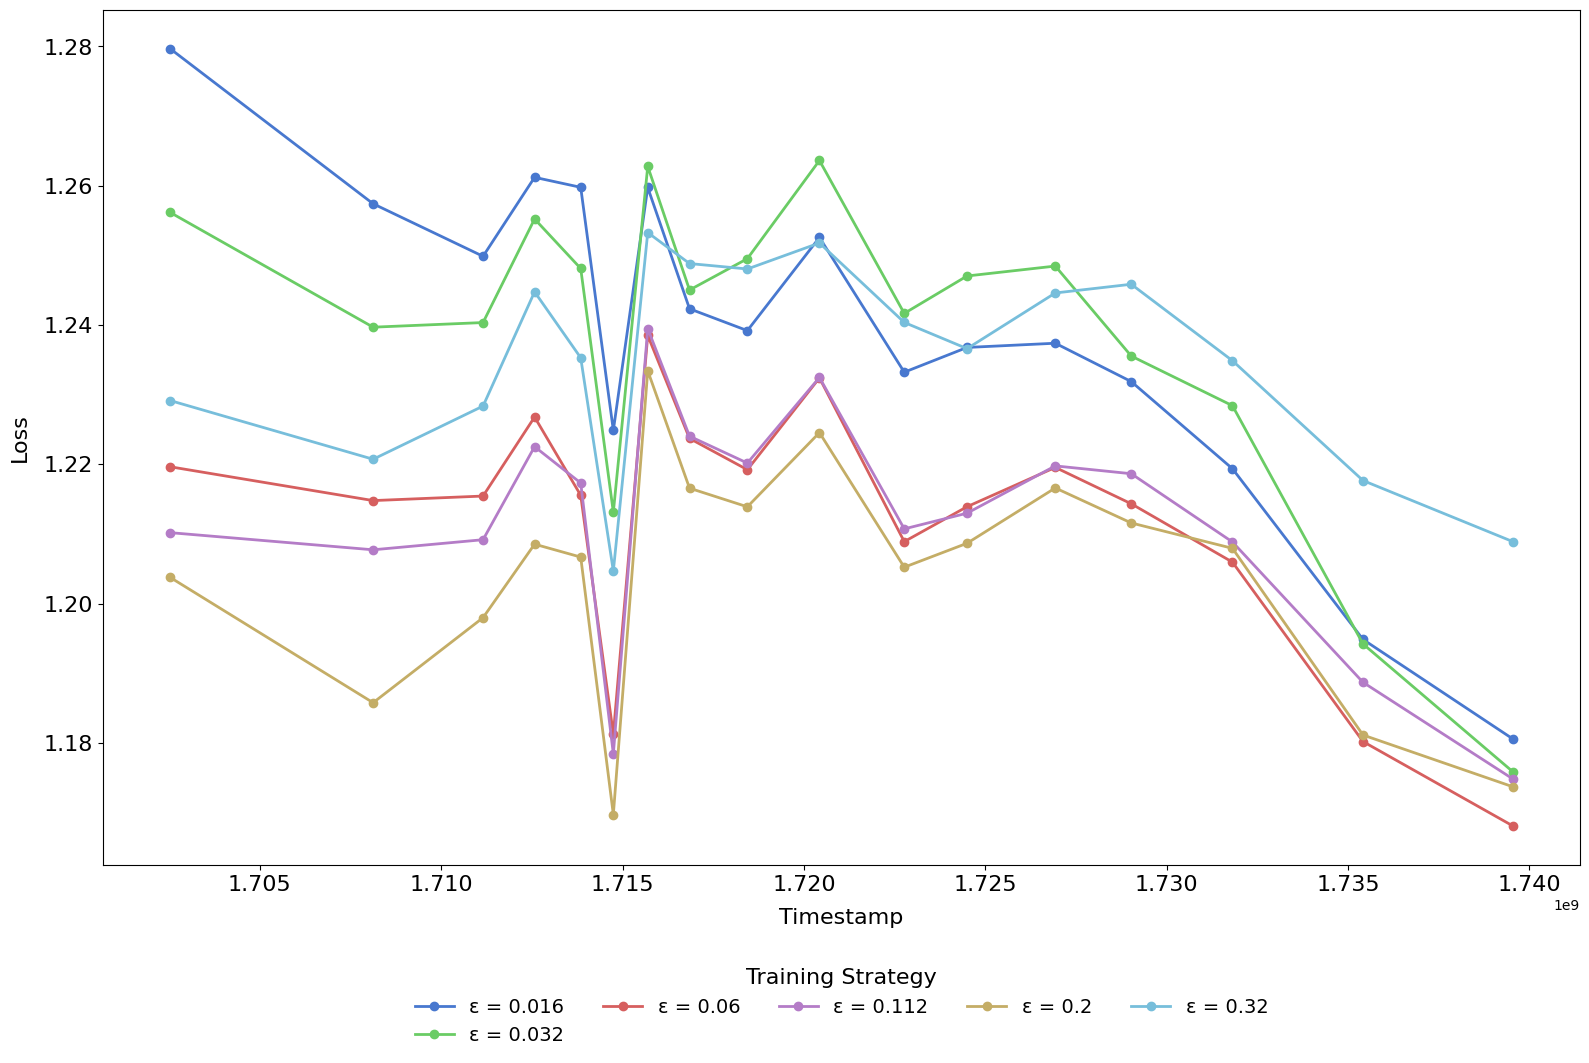

In [ ]:
plot_training_strategies_comparison(
    paths_with_labels= [
        ('checkpoint_results2/loss/output_eps_0.016.json', 'ε = 0.016'),
        ('checkpoint_results2/loss/output_eps_0.032.json', 'ε = 0.032'),
        ('checkpoint_results2/loss/output_eps_0.06.json', 'ε = 0.06'),
        ('checkpoint_results2/loss/output_eps_0.112.json', 'ε = 0.112'),
        ('checkpoint_results2/loss/output_eps_0.2.json', 'ε = 0.2'),
        ('checkpoint_results2/loss/output_eps_0.32.json', 'ε = 0.32'),
    ],
    title = 'Comparison of Replay Buffer Performance on Chronological Validation Data',
    ncols = 5
)

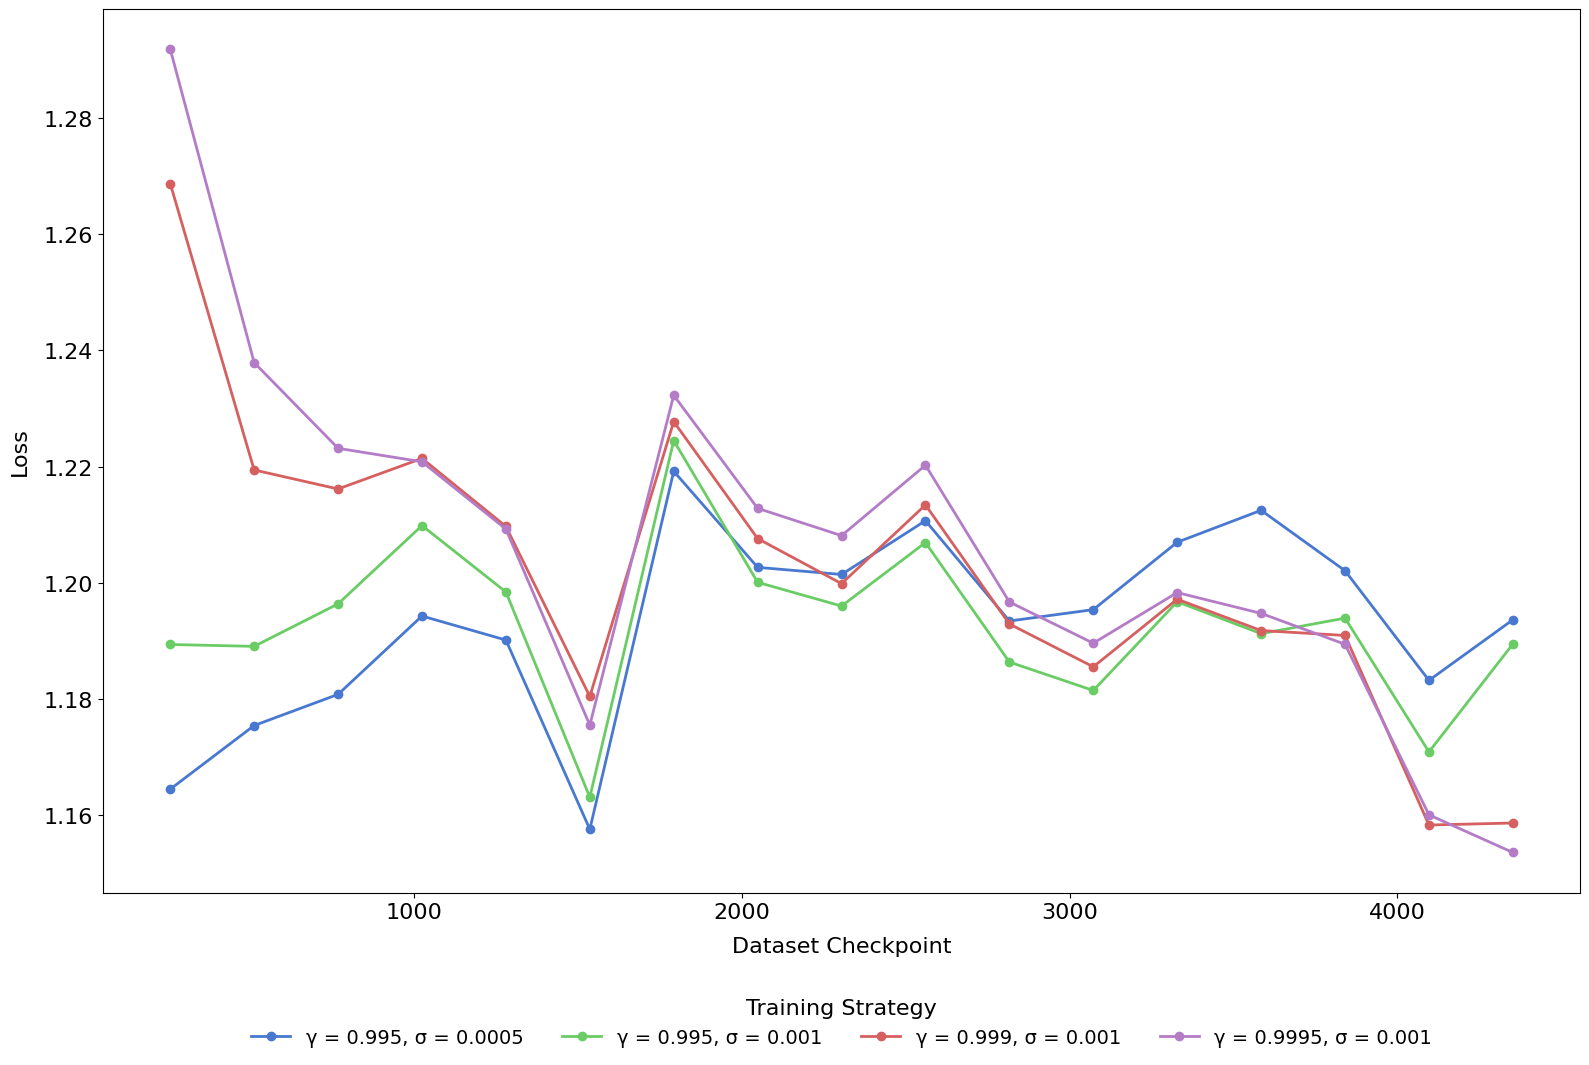

In [ ]:
plot_training_strategies_comparison(
    paths_with_labels= [
        ('checkpoint_results2/loss/output-geom-0.995-0.0005.json', 'γ = 0.995, η = 0.0005'),
        ('checkpoint_results2/loss/output-geom-0.995-0.001.json', 'γ = 0.995, η = 0.001'),
        #('checkpoint_results2/loss/output-geom-0.999-0.0005.json', 'γ = 0.999, σ = 0.0005'),
        ('checkpoint_results2/loss/output-geom-0.999-0.001.json', 'γ = 0.999, η = 0.001'),
        #('checkpoint_results2/loss/output-geom-0.9995-0.0005.json', 'γ = 0.9995, σ = 0.0005'),
        ('checkpoint_results2/loss/output-geom-0.9995-0.001.json', 'γ = 0.9995, η = 0.001'),
    ],
    
    title = 'Comparison of Geometric Buffer Performance on Chronological Validation Data',

)

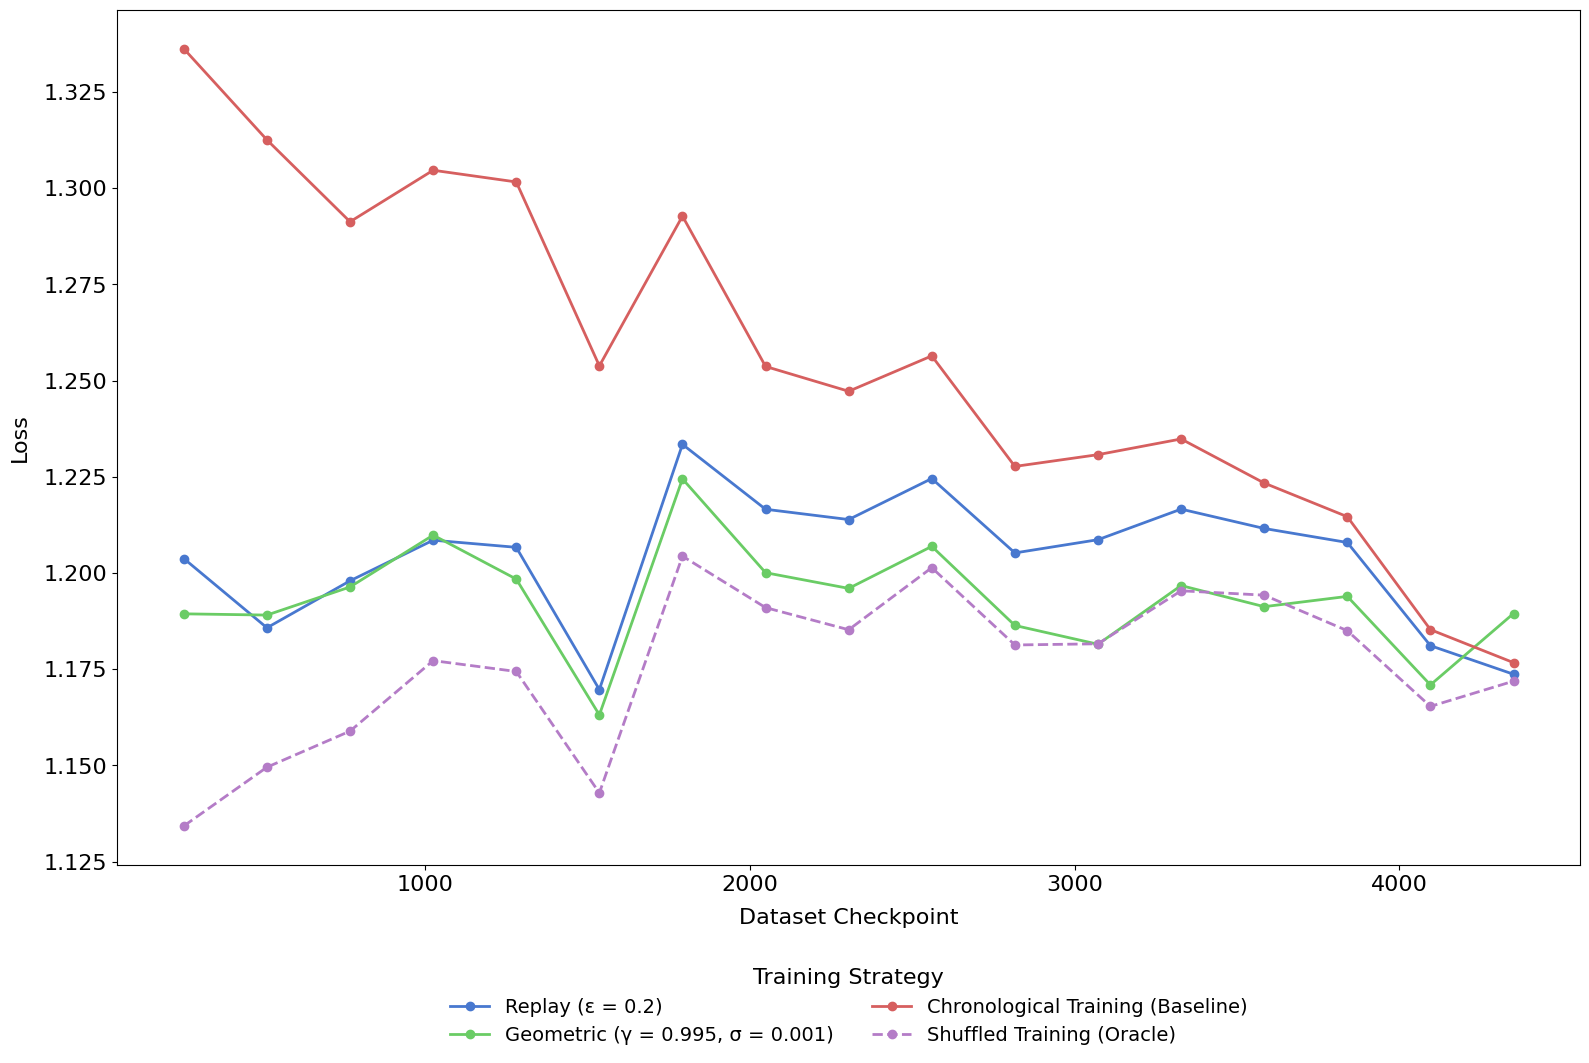

In [ ]:
plot_training_strategies_comparison(
    paths_with_labels= [
        ('checkpoint_results2/loss/output_eps_0.2.json', 'Replay (ε = 0.2)'),
        ('checkpoint_results2/loss/output-geom-0.995-0.001.json', 'Geometric (γ = 0.995, η = 0.001)'),
        ('checkpoint_results/naive_chrono_results.json', 'Chronological Training (Baseline)'),
        ('checkpoint_results/shuffled_cp_results.json', 'Shuffled Training (Oracle)')
    ],
    ncols = 2
)

In [4]:
plot_cp_results('checkpoint_results/naive_chrono_results.json', 'eval_plots2', 'naive_chrono_results', 'Chronological Baseline Loss Across Model and Dataset Checkpoints')

In [ ]:
def plot_multiple_jsons(json_paths, tstamp_files, labels):
    assert len(json_paths) == len(labels), "Each JSON path must have a corresponding label"

    plt.figure(figsize=(10, 6))

    for path, tstamp_file, label in zip(json_paths, tstamp_files, labels):
        with open(path, 'r') as file:
            data = json.load(file)
            
        with open(tstamp_file, 'r') as file:
            tstamp_file = json.load(file)
        
        x_vals = sorted([int(cp) for cp in data.keys()])
        tstamps = [tstamp_file[str(cp)] for cp in x_vals]
        y_vals = [np.mean(list(data[str(cp)].values())) for cp in x_vals]

        plt.plot(tstamps, y_vals, marker='o', label=label)

    plt.xlabel("Checkpoint Number")
    plt.ylabel("Mean Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


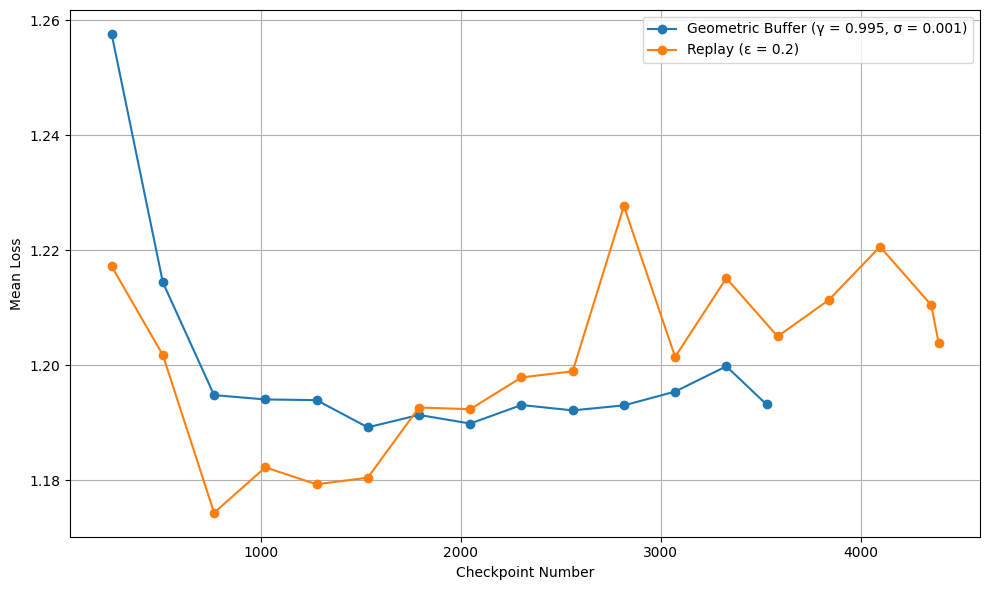

In [ ]:
json_files = [
    "checkpoint_results2/loss/output-geom-0.995-0.001.json",
    "checkpoint_results2/loss/output_eps_0.2.json",
]

tstamp_files = [
    "timestamps/output-geom-0.995-0.001.json",
    "timestamps/output_eps_0.2.json",
]

labels = [
    "Geometric Buffer (γ = 0.995, η = 0.001)",
    "Replay (ε = 0.2)",
]

plot_multiple_jsons(json_files, tstamp_files, labels)

float